## Evaluation

In [ ]:
%pip install deepeval ipywidgets

In [24]:
import json
import os
from deepeval.test_case import LLMTestCase
from deepeval.metrics import (ContextualPrecisionMetric, ContextualRecallMetric, ContextualRelevancyMetric)
from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def load_data_from_json(file_path):
    """Loads data from a single JSON file."""
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

def load_data_from_multiple_files(directory_path, file_extension="json"):
    """Loads data from multiple files (either JSON or JSONL)."""
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith(file_extension):
            file_path = os.path.join(directory_path, filename)
            if file_extension == "json":
                data.append(load_data_from_json(file_path))
    return data

In [11]:
def create_deep_eval_test_cases(questions, gt_answers, generated_answers, retrieved_documents):
    return [
        LLMTestCase(
            input=question,
            expected_output=gt_answer,
            actual_output=generated_answer,
            retrieval_context=retrieved_document
        )
        for question, gt_answer, generated_answer, retrieved_document in zip(
            questions, gt_answers, generated_answers, retrieved_documents
        )
    ]

In [18]:
def evaluate_test_cases(test_cases):    
    contextual_precision_scores = []
    contextual_recall_scores = []
    contextual_relevancy_scores = []
    answer_relevancy_scores = []
    faithfulness_scores = []
    # Run it for the first 50 test cases
    for i, test_case in enumerate(test_cases[:50]):
        print(f"Processing test case {i+1}/{len(test_cases)}")
        # retrieval metrics
        contextual_precision = ContextualPrecisionMetric()
        contextual_recall = ContextualRecallMetric()
        contextual_relevancy = ContextualRelevancyMetric()
        # generation metrics
        answer_relevancy = AnswerRelevancyMetric()
        faithfulness = FaithfulnessMetric()
        # evaluate
        contextual_precision.measure(test_case)
        print("Computed contextual precision")
        contextual_recall.measure(test_case)
        print("Computed contextual recall")
        contextual_relevancy.measure(test_case)
        print("Computed contextual relevancy")
        answer_relevancy.measure(test_case)
        print("Computed answer relevancy")
        faithfulness.measure(test_case)
        print("Computed faithfulness")
        # store results
        contextual_precision_scores.append(contextual_precision.score)
        contextual_recall_scores.append(contextual_recall.score)
        contextual_relevancy_scores.append(contextual_relevancy.score)
        answer_relevancy_scores.append(answer_relevancy.score)
        faithfulness_scores.append(faithfulness.score)
    return contextual_precision_scores, contextual_recall_scores, contextual_relevancy_scores, answer_relevancy_scores, faithfulness_scores

### Evaluation of RAG pipeline with the Simple Retriever

In [ ]:
directory_path = "qa_results_simple_retriever"
file_extension = "json"
data = load_data_from_multiple_files(directory_path, file_extension=file_extension)

In [5]:
questions = []
gt_answers = []
generated_answers = []
retrieved_documents = []
for item in data:
    questions.append(item["question"])
    gt_answers.append(item["ground_truth_answer"])
    generated_answers.append(item["generated_answer"])
    retrieved_documents.append(item["retrieved_documents"])

In [ ]:
test_cases_simple = create_deep_eval_test_cases(questions, gt_answers, generated_answers, retrieved_documents)
contextual_precision_scores, contextual_recall_scores, contextual_relevancy_scores, answer_relevancy_scores, faithfulness_scores = evaluate_test_cases(test_cases_simple)

In [ ]:
# Create DataFrame
df_scores_simple = pd.DataFrame({
    "Contextual Precision": contextual_precision_scores,
    "Contextual Recall": contextual_recall_scores,
    "Contextual Relevancy": contextual_relevancy_scores,
    "Answer Relevancy": answer_relevancy_scores,
    "Faithfulness": faithfulness_scores
})

df_scores_simple.head()

In [ ]:
# compute average scores
average_scores_simple = df_scores_simple.mean()
average_scores_simple

Contextual Precision    0.803333
Contextual Recall       0.643244
Contextual Relevancy    0.677705
Answer Relevancy        0.891988
Faithfulness            0.961027
dtype: float64

### Evaluation of the RAG Pipeline with the MMR Retriever

In [ ]:
directory_path = "qa_results_mmr_retriever"
file_extension = "json"
data_mmr = load_data_from_multiple_files(directory_path, file_extension=file_extension)
questions = []
gt_answers = []
generated_answers = []
retrieved_documents = []
for item in data_mmr:
    questions.append(item["question"])
    gt_answers.append(item["ground_truth_answer"])
    generated_answers.append(item["generated_answer"])
    retrieved_documents.append(item["retrieved_documents"])

test_cases_mmr = create_deep_eval_test_cases(questions, gt_answers, generated_answers, retrieved_documents)
contextual_precision_scores, contextual_recall_scores, contextual_relevancy_scores, answer_relevancy_scores, faithfulness_scores = evaluate_test_cases(test_cases_mmr)

In [ ]:
df_scores_mmr = pd.DataFrame({
    "Contextual Precision": contextual_precision_scores,
    "Contextual Recall": contextual_recall_scores,
    "Contextual Relevancy": contextual_relevancy_scores,
    "Answer Relevancy": answer_relevancy_scores,
    "Faithfulness": faithfulness_scores
})

df_scores_mmr

In [21]:
# compute average scores
average_scores_mmr = df_scores_mmr.mean()
average_scores_mmr

Contextual Precision    0.840000
Contextual Recall       0.643308
Contextual Relevancy    0.610674
Answer Relevancy        0.876248
Faithfulness            0.959725
dtype: float64

In [22]:
simple_retriever_scores = {
    "Contextual Precision": 0.803333,
    "Contextual Recall": 0.643244,
    "Contextual Relevancy": 0.677705,
    "Answer Relevancy": 0.891988,
    "Faithfulness": 0.961027
}

mmr_retriever_scores = {
    "Contextual Precision": 0.840000,
    "Contextual Recall": 0.643308,
    "Contextual Relevancy": 0.610674,
    "Answer Relevancy":  0.876248,
    "Faithfulness":  0.959725
}

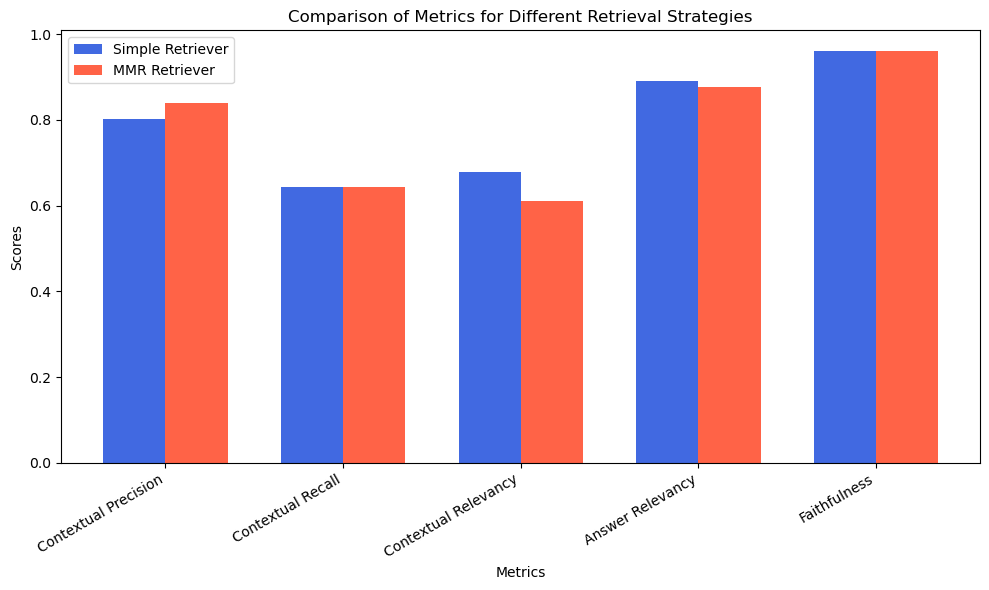

In [ ]:
# Extract metric names and values
metrics = list(simple_retriever_scores.keys())
values1 = list(simple_retriever_scores.values())
values2 = list(mmr_retriever_scores.values())

# Create the bar plot
x = np.arange(len(metrics))  
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, values1, width, label='Simple Retriever', color='royalblue')
bars2 = ax.bar(x + width/2, values2, width, label='MMR Retriever', color='tomato')
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Metrics for Different Retrieval Strategies")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=30, ha="right")
ax.legend()
plt.tight_layout()
plt.show()